# (24) Simulation -- generate (fix & obj uncoupled)

**Motivation**: Show all the distributions (ground truth generative facotrs, as well as emergent velocities).  Starting from here, I will be using ```Simulation``` which better decouples fix and obj x and y. But it is still not ideal (0.1 corr, see below). 

- ***Open question***: how to effectively sample obj x,y such that it is truly independent and uniform?
<br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from model.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def show_thetaphi(t, p):
    fig, axes = create_figure(1, 4, (13, 2.5), tight_layout=True)
    im = axes[0].imshow(t, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[0])

    im = axes[2].imshow(p, cmap='hsv', vmin=0, vmax=2*np.pi)
    plt.colorbar(im, ax=axes[2])

    for ax in [axes[0], axes[2]]:
        ax.invert_yaxis()
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=of.ticks,
            yticks=of.ticks,
            xticklabels=of.ticklabels,
            yticklabels=of.ticklabels,
        )

    axes[1].axvline(np.deg2rad(fov), color='r', ls='--', label=f'{fov} deg')
    sns.histplot(
        t.ravel(), ax=axes[1], label=r'$\theta$',
        bins=np.linspace(0, np.pi/2, 91), stat='count')
    sns.histplot(
        p.ravel(), ax=axes[3], label=r'$\phi$', color='C0',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    
    sns.histplot(
        p[t <= np.deg2rad(fov)], ax=axes[3], label=r'$\phi$' + f' (<{fov})', color='C1',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    for ax in [axes[1], axes[3]]:
        ax.set_ylabel('')
        ax.legend(fontsize=8, loc='upper left')

    plt.show()
    
    
def show_xyzd(x, y, z, d, cmap='Spectral', grid=False):
    fig, axes = create_figure(1, 4, (12, 2.5), 'all', 'all', tight_layout=True)
    im = axes[0].imshow(x, cmap=cmap)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title(r'$\mathcal{x}$', y=1.02, fontsize=17)

    im = axes[1].imshow(y, cmap=cmap)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title(r'$\mathcal{y}$', y=1.02, fontsize=17)

    im = axes[2].imshow(z, cmap=cmap)
    plt.colorbar(im, ax=axes[2])
    axes[2].set_title(r'$\mathcal{z}$', y=1.02, fontsize=17)

    im = axes[3].imshow(d, cmap=cmap)
    plt.colorbar(im, ax=axes[3])
    axes[3].set_title(r'$\mathcal{d} = \sqrt{\mathcal{x}^2+\mathcal{y}^2+\mathcal{z}^2}$', y=1.02, fontsize=14)

    axes[-1].invert_yaxis()
    for ax in axes.flat:
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=of.ticks,
            yticks=of.ticks,
            xticklabels=of.ticklabels,
            yticklabels=of.ticklabels,
        )
    if grid:
        add_grid(axes)
    plt.show()
    
    
def hist_xyzd(x, y, d, z=None, bins=30):
    kws = {
        'bins': bins,
        'stat': 'percent',
    }
    fig, axes = create_figure(2, 4, (13, 5), sharey='all', constrained_layout=True)
    sns.histplot(x.ravel(), ax=axes[0, 0], **kws)
    sns.histplot(y.ravel(), ax=axes[0, 1], **kws)
    if z is not None:
        sns.histplot(z.ravel(), ax=axes[0, 2], **kws)
    sns.histplot(d.ravel(), ax=axes[0, 3], **kws)

    sns.histplot(x[of.theta < np.deg2rad(fov)], ax=axes[1, 0], **kws)
    sns.histplot(y[of.theta < np.deg2rad(fov)], ax=axes[1, 1], **kws)
    if z is not None:
        sns.histplot(z[of.theta < np.deg2rad(fov)], ax=axes[1, 2], **kws)
    sns.histplot(d[of.theta < np.deg2rad(fov)], ax=axes[1, 3], **kws)
    
    axes[0, 0].set_title(r'$x$', y=1.02, fontsize=17)
    axes[0, 1].set_title(r'$y$', y=1.02, fontsize=17)
    axes[0, 2].set_title(r'$z$', y=1.02, fontsize=17)
    axes[0, 3].set_title(r'$d$', y=1.02, fontsize=17)
    
    plt.show()
    

def show_velocity(v, cmap='Spectral_r', grid=False):
    rho, phi = vel2polar(v)
    vminmax = np.max(np.abs(v))
    kws = dict(
        cmap='bwr',
        vmax=vminmax,
        vmin=-vminmax,
    )
    fig, axes = create_figure(1, 4, (12, 2.5), 'all', 'all', tight_layout=True)
    im = axes[0].imshow(v[..., 0], **kws)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title(r'$v_x$', y=1.02, fontsize=17)

    im = axes[1].imshow(v[..., 1], **kws)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title(r'$v_y$', y=1.02, fontsize=17)

    im = axes[2].imshow(rho, cmap=cmap)
    plt.colorbar(im, ax=axes[2])
    axes[2].set_title(r'$\rho$', y=1.02, fontsize=17)

    im = axes[3].imshow(phi, cmap='hsv', vmin=0, vmax=2*np.pi)
    plt.colorbar(im, ax=axes[3])
    axes[3].set_title(r'$\phi$', y=1.02, fontsize=14)

    axes[-1].invert_yaxis()
    for ax in axes.flat:
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=of.ticks,
            yticks=of.ticks,
            xticklabels=of.ticklabels,
            yticklabels=of.ticklabels,
        )
    if grid:
        add_grid(axes)
    plt.show()


from skimage.transform import resize

def show_opticflow(v, dims=None):
    dims = dims if dims else [2, 4, 8]
    fig, axes = create_figure(1, 3, (12, 4), constrained_layout=True)
    for i, d in enumerate(dims):
        axes[i].quiver(
            range(-d, d + 1),
            range(-d, d + 1),
            resize(v[..., 0], (2*d+1,) * 2),
            resize(v[..., 1], (2*d+1,) * 2),
        )
    ax_square(axes)
    plt.show()
    return

## Sampler

In [3]:
fov = 45
dim = 19
res = 2 * fov / (dim - 1)
num = int(5e5)
self = sim = Simulation(num, fov, res)
of = OpticFlow(fov, res).compute_coords()

In [4]:
%%time

_ = sim.sample()

CPU times: user 4min 32s, sys: 96.6 ms, total: 4min 32s
Wall time: 4min 32s


In [5]:
%%time

_ = sim.fit_sim()

CPU times: user 2min 52s, sys: 20.3 s, total: 3min 13s
Wall time: 3min 2s


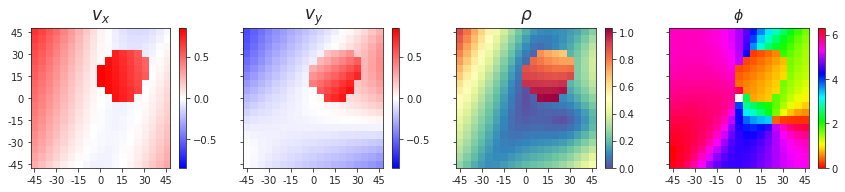

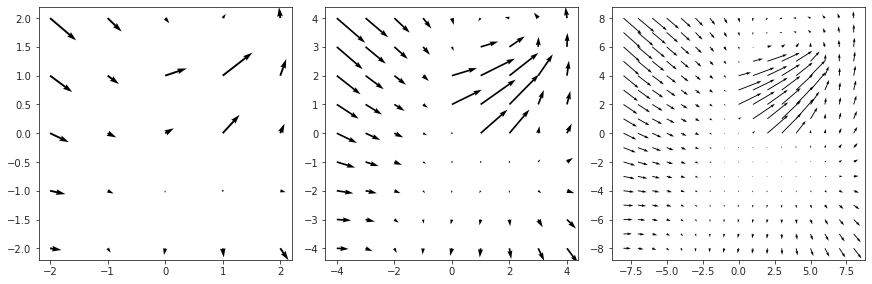

In [6]:
ii = 1982
show_velocity(sim.alpha_dot[ii])
show_opticflow(sim.alpha_dot[ii])

## Plot distributions (ground truth)

### 1) Fix + object pos

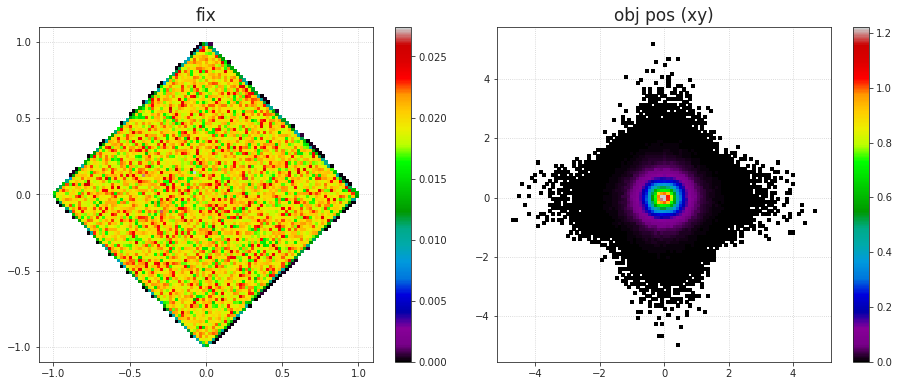

In [7]:
fig, axes = create_figure(1, 2, (13, 5.2), tight_layout=True)
kws = dict(
    stat='percent',
    bins=100,
    cbar=True,
    cmap='nipy_spectral',
)
sns.histplot(
    x=self.fix[:, 0],
    y=self.fix[:, 1],
    ax=axes[0],
    **kws,
)
sns.histplot(
    x=self.pos_obj[0],
    y=self.pos_obj[1],
    ax=axes[1],
    **kws,
)
# sns.histplot(self.pos_obj[2], ax=axes[2], bins=kws['bins'], stat=kws['stat'])
for ax in axes:
    ax.locator_params(axis='both', nbins=7)
    ax_square(ax)
# axes[2].set_ylabel('')
add_grid(axes)

axes[0].set_title('fix', fontsize=17)
axes[1].set_title('obj pos (xy)', fontsize=17)
# axes[2].set_title('obj pos (z)', fontsize=17)

plt.show()

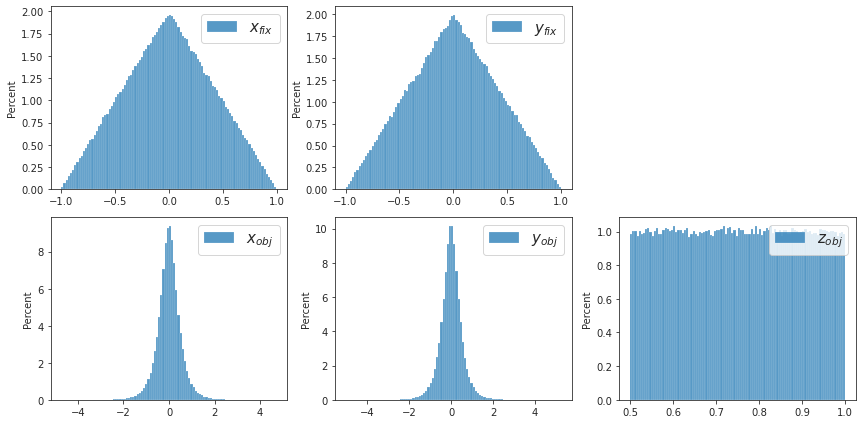

In [8]:
fig, axes = create_figure(2, 3, (12, 6.0), tight_layout=True)
kws = dict(
    stat='percent',
    bins=100,
)
lbl_fix = (r'$x_{fix}$', r'$y_{fix}$')
lbl_pos = (r'$x_{obj}$', r'$y_{obj}$', r'$z_{obj}$')
for i in range(3):
    if i < 2:
        sns.histplot(
            self.fix[:, i],
            label=lbl_fix[i],
            ax=axes[0, i],
            **kws,
        )
        axes[0, i].legend(fontsize=15)
    else:
        axes[0, i].remove()
    sns.histplot(
        self.pos_obj[i],
        label=lbl_pos[i],
        ax=axes[1, i],
        **kws,
    )
    axes[1, i].legend(fontsize=15)

plt.show()

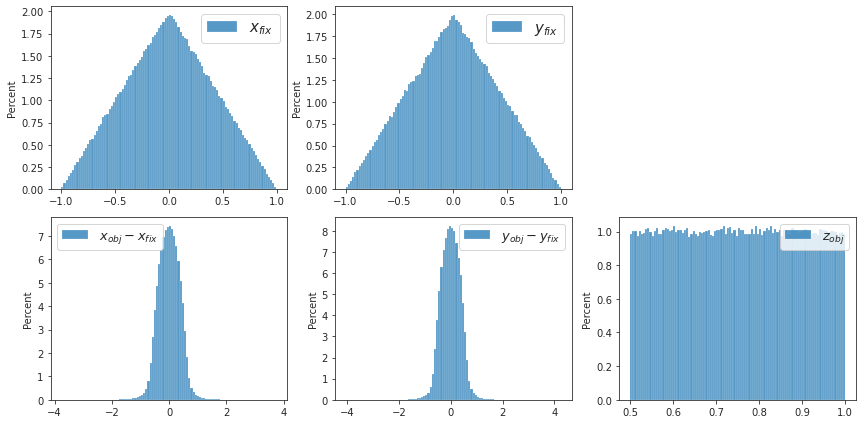

In [9]:
fig, axes = create_figure(2, 3, (12, 6.0), tight_layout=True)
kws = dict(
    stat='percent',
    bins=100,
)
lbl_fix = (r'$x_{fix}$', r'$y_{fix}$')
lbl_pos = (r'$x_{obj} - x_{fix}$', r'$y_{obj} - y_{fix}$', r'$z_{obj}$')
for i in range(3):
    if i < 2:
        sns.histplot(
            self.fix[:, i],
            label=lbl_fix[i],
            ax=axes[0, i],
            **kws,
        )
        axes[0, i].legend(fontsize=15)
        sns.histplot(
            self.pos_obj[i] - self.fix[:, i],
            label=lbl_pos[i],
            ax=axes[1, i],
            **kws,
        )
    else:
        axes[0, i].remove()
        sns.histplot(
            self.pos_obj[i],
            label=lbl_pos[i],
            ax=axes[1, i],
            **kws,
        )
    axes[1, i].legend(fontsize=13)

plt.show()

### 2) Self velocity

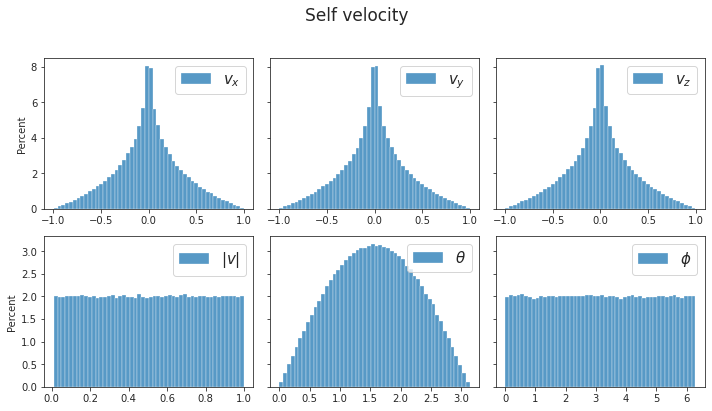

In [10]:
fig, axes = create_figure(2, 3, (10, 5.5), sharey='row', tight_layout=True)
v_polar = cart2polar(self.vel_slf.T)
lbl_cart = (r'$v_x$', r'$v_y$', r'$v_z$')
lbl_polar = (r'$|v|$', r'$\theta$', r'$\phi$')
kws = dict(stat='percent', bins=50)
for i in range(3):
    sns.histplot(self.vel_slf[i], label=lbl_cart[i], ax=axes[0, i], **kws)
    sns.histplot(v_polar[:, i], label=lbl_polar[i], ax=axes[1, i], **kws)
for ax in axes.flat:
    ax.legend(fontsize=15)
    ax.locator_params(nbins=7)
fig.suptitle('Self velocity', fontsize=17, y=1.03)
plt.show()

### 3) Obj velocity

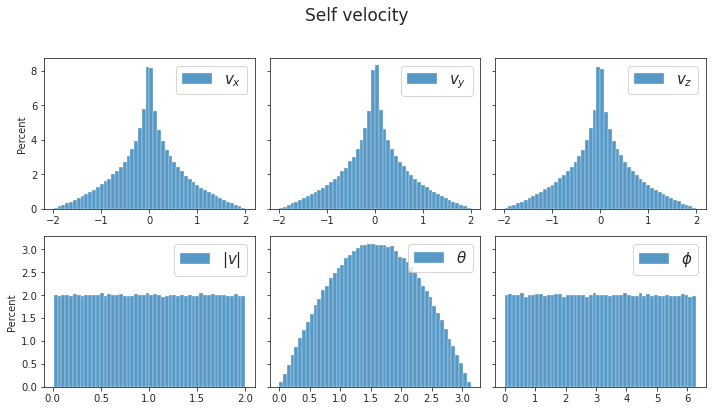

In [11]:
fig, axes = create_figure(2, 3, (10, 5.5), sharey='row', tight_layout=True)
v_polar = cart2polar(self.vel_obj.T)
lbl_cart = (r'$v_x$', r'$v_y$', r'$v_z$')
lbl_polar = (r'$|v|$', r'$\theta$', r'$\phi$')
kws = dict(stat='percent', bins=50)
for i in range(3):
    sns.histplot(self.vel_obj[i], label=lbl_cart[i], ax=axes[0, i], **kws)
    sns.histplot(v_polar[:, i], label=lbl_polar[i], ax=axes[1, i], **kws)
for ax in axes.flat:
    ax.legend(fontsize=15)
    ax.locator_params(nbins=7)
fig.suptitle('Self velocity', fontsize=17, y=1.03)
plt.show()

## Plot distributions (emergent)

In [12]:
rho, theta = vel2polar(sim.alpha_dot)
rho.shape

(500000, 19, 19)

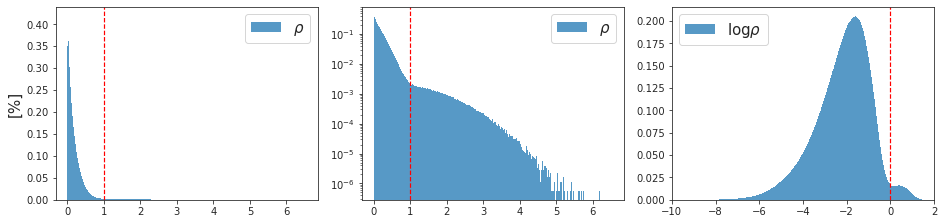

In [13]:
fig, axes = create_figure(1, 3, (13, 3), constrained_layout=True)
sns.histplot(rho.ravel(), stat='percent', label=r'$\rho$', ax=axes[0])
sns.histplot(rho.ravel(), stat='percent', label=r'$\rho$', ax=axes[1])
sns.histplot(np.log(rho[rho.nonzero()]), label=r'$\log \rho$', stat='percent', ax=axes[2])

for ax in axes.flat:
    ax.set_ylabel('')
    ax.legend(fontsize=15)
for ax in axes[:2].flat:
    ax.axvline(1, color='r', ls='--', lw=1.2)

axes[0].set_ylabel('[%]', fontsize=15)
axes[1].set_yscale('log')
axes[2].set_xlim(-10, 2)
axes[2].axvline(0, color='r', ls='--', lw=1.2)

plt.show()

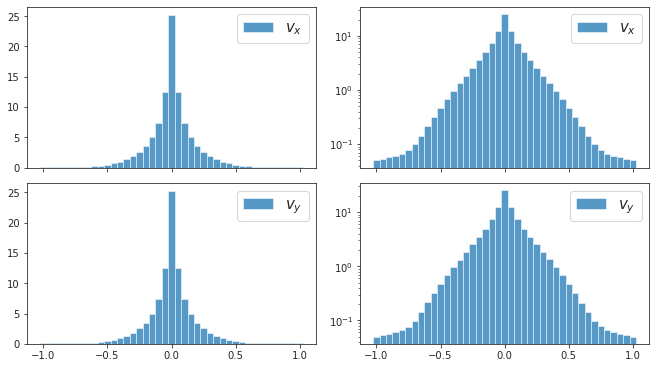

In [14]:
n = 40
bins = np.linspace(-1, 1 + 2 / n, n + 2) - 1 / n

fig, axes = create_figure(2, 2, figsize=(9, 5), sharex='all', sharey='col', constrained_layout=True)
for i in range(2):
    lbl = r'$v_x$' if i == 0 else r'$v_y$'
    sns.histplot(sim.alpha_dot[..., i].ravel(), label=lbl, bins=bins, stat='percent', ax=axes[i, 0])
    sns.histplot(sim.alpha_dot[..., i].ravel(), label=lbl, bins=bins, stat='percent', ax=axes[i, 1])
    axes[i, 1].set_yscale('log')
for ax in axes.flat:
    ax.set_ylabel('')
    ax.legend(fontsize=15)
plt.show()

In [15]:
ii, xx, yy = np.unravel_index(np.argmax(rho), rho.shape)
ii, xx, yy

(72408, 18, 8)

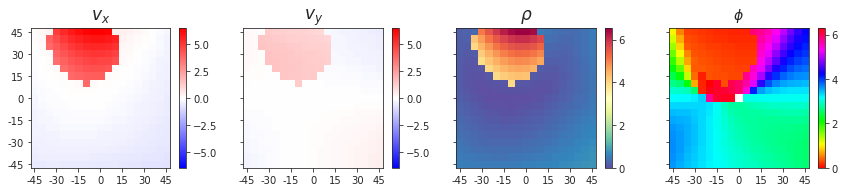

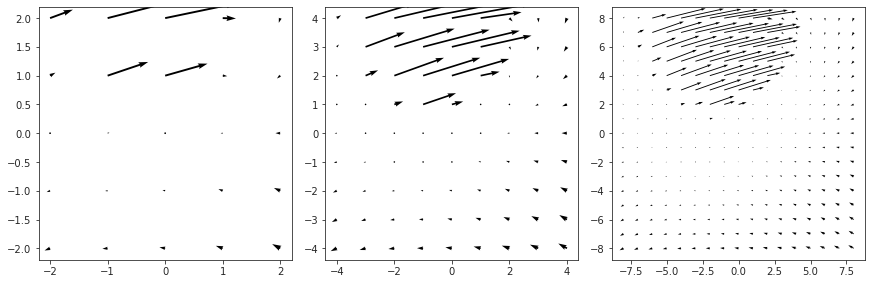

In [16]:
show_velocity(sim.alpha_dot[ii])
show_opticflow(sim.alpha_dot[ii])

In [17]:
ii, xx, yy = np.unravel_index(np.argmin(rho), rho.shape)
ii, xx, yy

(18, 9, 9)

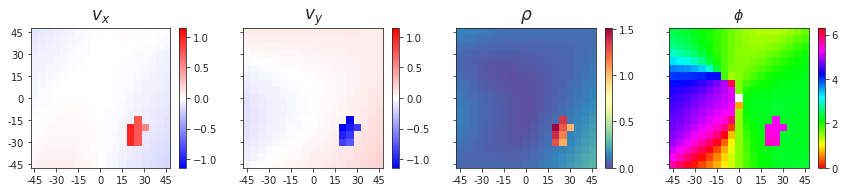

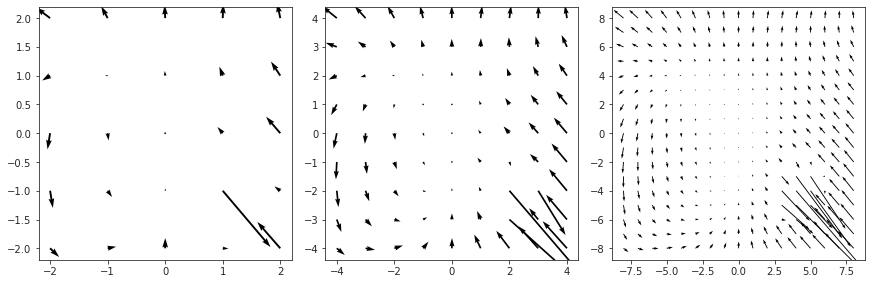

In [18]:
show_velocity(sim.alpha_dot[ii])
show_opticflow(sim.alpha_dot[ii])

In [19]:
ii = np.argmax(rho.mean(1).mean(1))
ii

494707

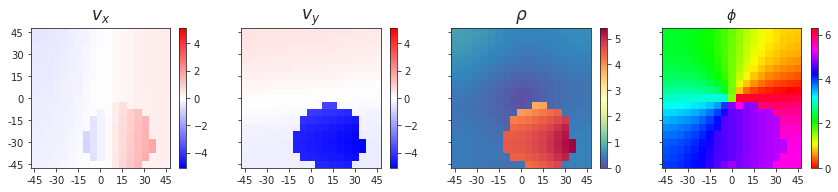

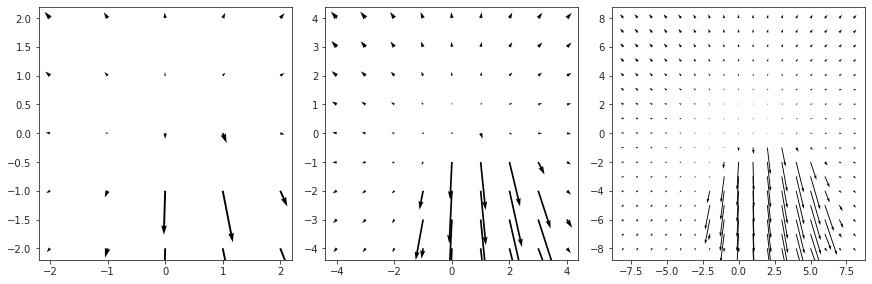

In [20]:
show_velocity(sim.alpha_dot[ii])
show_opticflow(sim.alpha_dot[ii])

In [21]:
ii = np.argmin(rho.mean(1).mean(1))
ii

24821

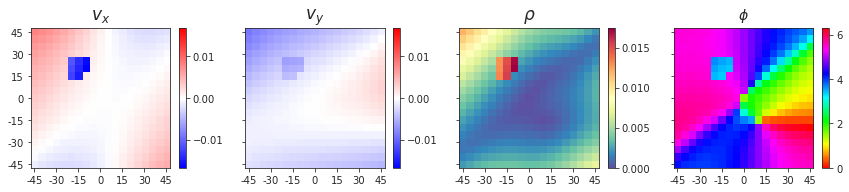

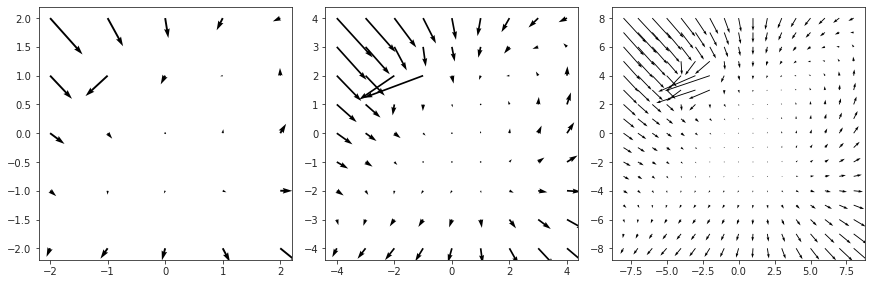

In [22]:
show_velocity(sim.alpha_dot[ii])
show_opticflow(sim.alpha_dot[ii])

In [23]:
self.vel_obj[:, ii]

array([-0.0234264 , -0.00033229,  0.00122364])

In [24]:
self.vel_slf[:, ii]

array([ 0.00520589, -0.0085408 ,  0.00295407])

## Correlation structure of generative factors

### All original variables

In [25]:
g = np_nans((num, 11))
g[:, :2] = self.fix
g[:, 2:5] = self.vel_slf.T
g[:, 5:8] = self.vel_obj.T
g[:, 8:11] = self.pos_obj.T
g.shape

(500000, 11)

In [26]:
d = sp_dist.squareform(sp_dist.pdist(g.T, metric='correlation'))
corr = 1 - d
np.fill_diagonal(corr, 0.)
corr.shape

(11, 11)

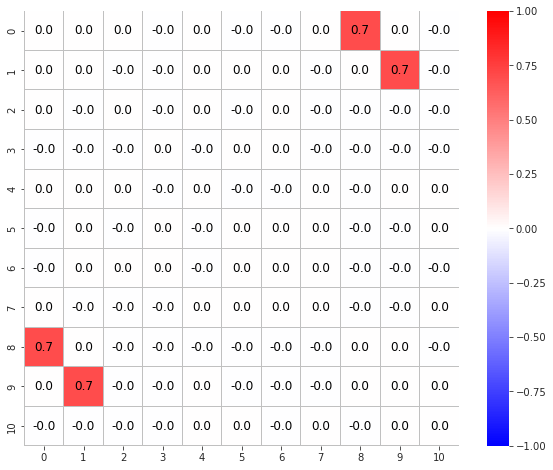

In [27]:
fig, ax = create_figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    cmap='bwr',
    annot=True,
    fmt='0.1f',
    annot_kws={'fontsize': 12, 'color': 'k'},
    linecolor='silver',
    linewidths=0.01,
    ax=ax,
)
ax_square(ax)
plt.show()

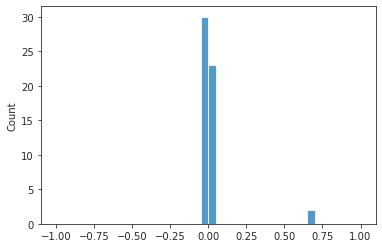

In [28]:
sns.histplot(sp_dist.squareform(corr), bins=np.linspace(-1, 1, 41));

In [29]:
np.where(corr > 0.7)

(array([], dtype=int64), array([], dtype=int64))

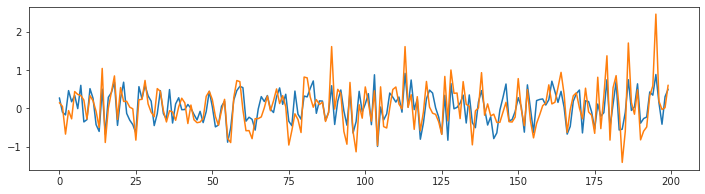

In [30]:
fig, ax = create_figure(figsize=(12, 3))
intvl = range(200)
ax.plot(self.fix[:, 0][intvl])
ax.plot(self.pos_obj[0][intvl])

### Pos of object relative to fix

In [31]:
pos = dc(self.pos_obj)
pos[0] -= self.fix[:, 0]
pos[1] -= self.fix[:, 1]

In [32]:
g = np_nans((num, 11))
g[:, :2] = self.fix
g[:, 2:5] = self.vel_slf.T
g[:, 5:8] = self.vel_obj.T
g[:, 8:11] = pos.T
g.shape

(500000, 11)

In [33]:
d = sp_dist.squareform(sp_dist.pdist(g.T, metric='correlation'))
corr = 1 - d
np.fill_diagonal(corr, 0.)
corr.shape

(11, 11)

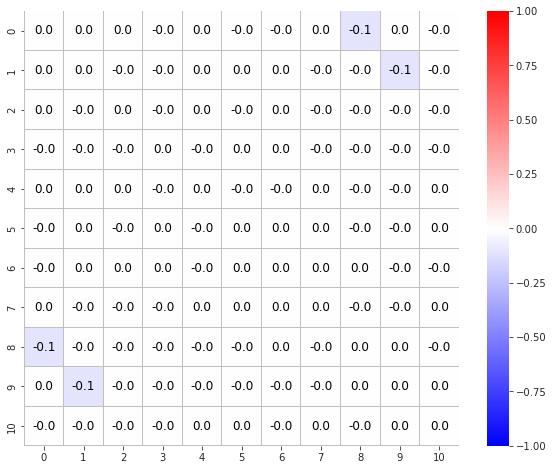

In [34]:
fig, ax = create_figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    cmap='bwr',
    annot=True,
    fmt='0.1f',
    annot_kws={'fontsize': 12, 'color': 'k'},
    linecolor='silver',
    linewidths=0.01,
    ax=ax,
)
ax_square(ax)
plt.show()

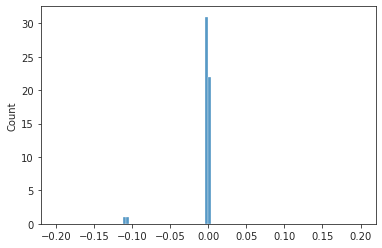

In [35]:
sns.histplot(sp_dist.squareform(corr), bins=np.linspace(-0.2, 0.2, 101));